# Procesos estocásticos en tiempo continuo

El ajuste a datos reales se logra con reescalamiento y combinación de procesos simulados de Weiner.
Empiezo por simulación de procesos individuales.


# Movimiento Browniano

### Convenciones:
Matriz de d trayectorias de una serie de n tiempos será matriz d x n. 


Trayectoria==individuo, cada tiempo una variable

Simulación de browniano:
$$B_{t+1}=B_t+\sqrt{t} Z_t, \quad Z_t~N(0,1)$$ 

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional
import brownian_motion as bm

size dB:  10001
Size B:  10001


(array([-0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2]),
 [Text(0, -0.2, '−0.2'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4000000000000001, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0000000000000002, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

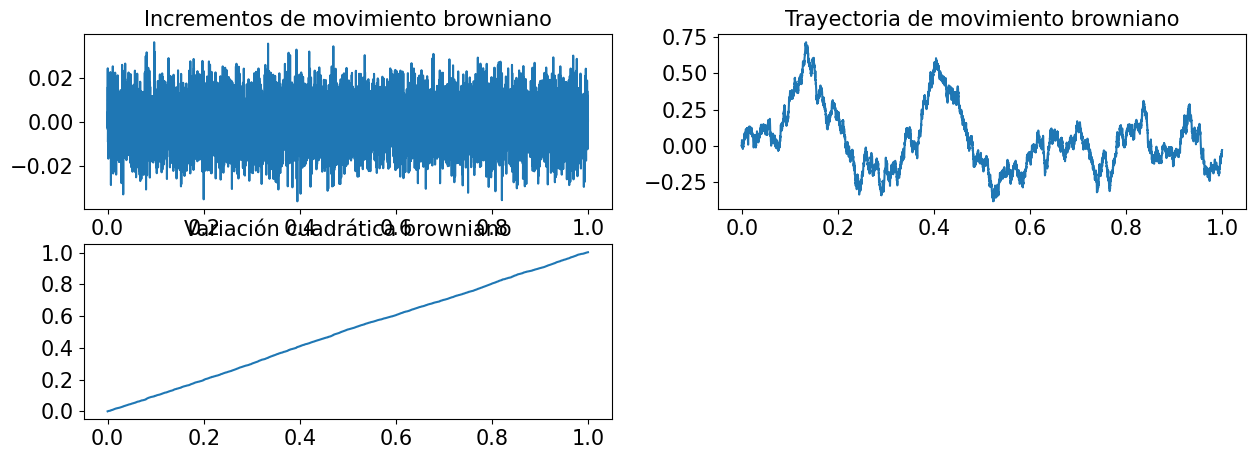

In [35]:
#simulación individual

T=1#Horizonte de tiempo
n=10000 # num de subintervalos
d=5
time=np.linspace(0,T,n+1)#Con n+1 puntos obtengo 0=t_0<...<t_n=T, n subintervalos
dt=T/n

dB=bm.get_dB(n+1,dt=dt,random_state=5)
print("size dB: ", dB.size)
B=bm.get_B(n+1,dt=dt,random_state=5) 
print("Size B: ", B.size)


# dB = get_dB(1_000)
# B  = get_B(1_000)

fig = plt.figure(figsize=(15, 5))

title = "Incrementos de movimiento browniano"
plt.subplot(2, 2, 1)
plt.plot(time,dB.T) #basta plt.plot(dB.T) si el dt=1
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Trayectoria de movimiento browniano"
plt.subplot(2, 2, 2)
plt.plot(time, B.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Variación cuadrática browniano"
plt.subplot(2, 2, 3)
plt.plot(time,bm.quadratic_variation(B).T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)




### Correlacionados y matriz de d trayectorias
$W_3$ correlacionado con $W_1$. Con la relación $$dW_3(t)=\rho dW_1(t)+\sqrt{1-\rho^2}dW_2(t)$$
Se tiene que $corr(W_1,W_3)=\rho$.

Usualmente necesitaré múltiplos procesos. El segundo proceso correlacionado por $\rho$ con el primero, el segundo correlacionado por $\rho$ con una elección aleatoria de los procesos ya generados. Simularé una matriz con cada columna como un proceso browniano. 

La matriz será (dxn). Con $\rho=0$ o None, tengo d trayectorias independientes.

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 [Text(0, 0.5, '0'),
  Text(0, 1.5, '1'),
  Text(0, 2.5, '2'),
  Text(0, 3.5, '3'),
  Text(0, 4.5, '4'),
  Text(0, 5.5, '5'),
  Text(0, 6.5, '6'),
  Text(0, 7.5, '7'),
  Text(0, 8.5, '8'),
  Text(0, 9.5, '9')])

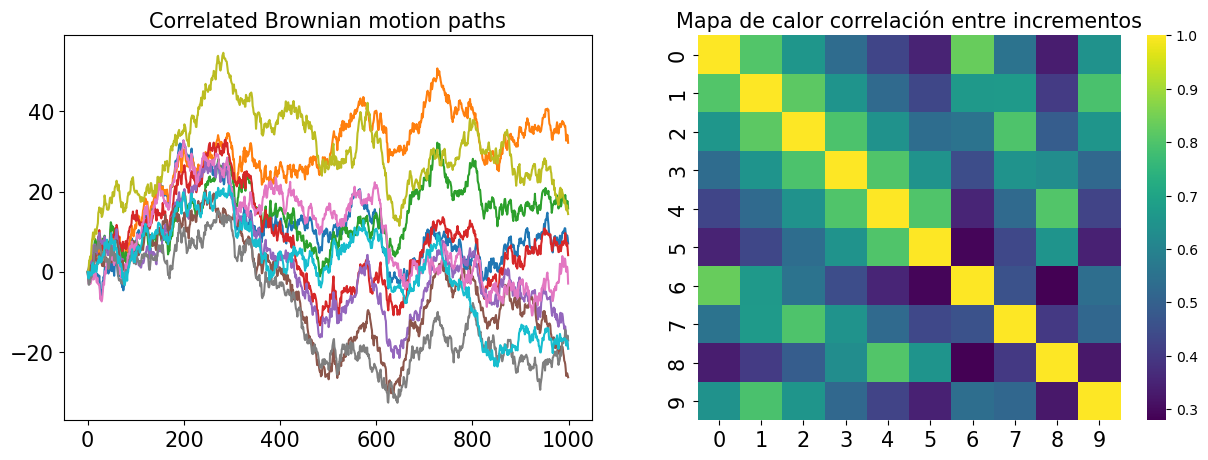

In [36]:
T = 1_000
n_procs = 10
rho = 0.8

#En caso de usar dt
corr_Bs = bm.get_B_matrix(T, n_procs,rho=rho)
corr_dBs=bm.dif_B(corr_Bs)
#Plot
fig = plt.figure(figsize=(15, 5))

# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(corr_Bs.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Mapa de calor correlación entre incrementos"
plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
sns.heatmap(np.corrcoef(corr_dBs, rowvar=True), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# title = "Mapa de calor correlación entre trayectorias"
# plt.subplot(1, 2, 2)
# sns.heatmap(np.corrcoef(corr_Bs, rowvar=True), cmap="viridis") #Si lo hago con la matriz de las trayectorias no sería más preciso? Bsuco las correlaciones entre los W_t
# plt.gca().set_title(title, fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)



## Medidas de error

In [37]:
###Obtención de estadísticos de matriz de datos (d x n) tomando cada columna (tiempo t) como variable
def empiric_matrix_stats(B:np.array):
    """
    Recibe: 
    B: matriz (d x n) de d trayectorias de dimensión n. 
    Retorna: 
    mu_hat_t: vector de función esperanza estimada (func de t) y
    cov_hat_st: matriz que estima función de covarianza (func de s y t). 
    En cada caso, mu_hat_t[i] será la estimación de E(W_{i*dt}) mientras que 
    cov_hat_st[i,j] será estimación de Cov(W_{i*dt},W_{j*dt}) para el dt elegido al momento de simular.

    """
    if B.ndim==1:
        raise Exception("Argument not a matrix")
    else: 
        d,n=B.shape
        mu_hat_t=np.mean(B,axis=0)
        cov_hat_st=np.cov(B,rowvar=False) #Puedo obtener la estimación de varianzas con np.diag(cov)
    return mu_hat_t, cov_hat_st
    

###Medidas de error:
def mse(y:np.array,y_hat:np.array)->float:
    return np.mean(np.square(y-y_hat))

def mae(y:np.array,y_hat:np.array)->float:
    return np.mean(np.abs(y-y_hat))


# Movimientos asociados




###  Movimiento browniano bridge   


(100, 1000)


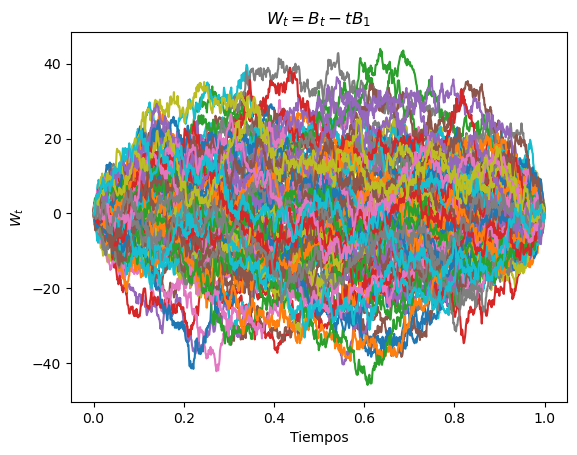

(array([ 0.00000000e+00,  9.93123386e-02,  2.94099667e-01,  3.04669422e-01,
         3.57845204e-01,  5.82940091e-01,  5.51038841e-01,  6.46664527e-01,
         4.83629207e-01,  6.28396217e-01,  6.83173835e-01,  8.33317694e-01,
         7.08191191e-01,  7.33335647e-01,  6.16451052e-01,  6.05360404e-01,
         5.77406277e-01,  6.42012958e-01,  6.06719846e-01,  7.55549093e-01,
         6.54829006e-01,  6.78664086e-01,  5.91461899e-01,  6.45318618e-01,
         5.74473757e-01,  5.06661756e-01,  6.31149542e-01,  6.65873488e-01,
         8.25964463e-01,  8.67901013e-01,  8.85386541e-01,  7.66349100e-01,
         7.97784344e-01,  8.07537826e-01,  7.90714902e-01,  6.62498022e-01,
         6.10421724e-01,  6.46830891e-01,  5.15208631e-01,  6.19069881e-01,
         6.19181915e-01,  4.70958597e-01,  4.53799310e-01,  2.31749030e-01,
         2.80951129e-01,  1.26717264e-01,  1.14754904e-01,  5.18719209e-02,
         1.05669980e-01, -3.34197818e-02,  3.24593679e-02, -2.54990075e-02,
        -1.2

In [33]:
n=1000
d=100
Bridge=bm.get_Bridge_matrix(n,d)
print(Bridge.shape)
# Graficamos el movimiento browniano de Bridge
fig, ax = plt.subplots()
ax.plot(np.linspace(0,1,n),Bridge.T)
ax.set_title("$W_t = B_t -tB_1$")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show() 




#Medidas de centraldiad y dispersión:
#Media: (cada columna (Bridge[:,i]) es muestra de W_t para t=i*dt)



#Varianza

#Covarianza
empiric_matrix_stats(Bridge)


# title = "$W_t = B_t -tB_1$"
# plt.subplot(1, 2, 1)
# plt.plot(np.linspace(0,1,n),Bridge.T)
# plt.gca().set_title(title, fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

# title = "Correlated Brownian motion paths"
# plt.subplot(1, 2, 2)
# plt.plot(np.linspace(0,1,n),Bridge.T)
# plt.gca().set_title(title, fontsize=15)
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)

### Ruido gaussiano blanco (coloreado?)

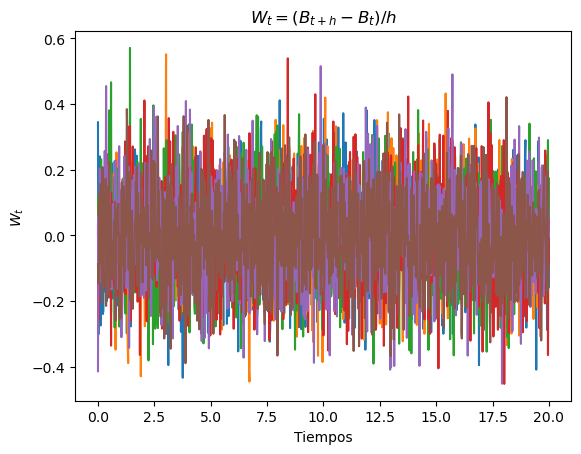

In [17]:
def get_Gaussian_matrix(n:int, d:int, h: int=1, dt:float=1, random_state=None)->np.array:
    """
    Recibe:
    n: tamaño por trayectoria.
    d:
    h: (h<n) tamaño del incremento temporal en número de pasos dt . (h*dt)
    Retorna:
    Matriz (d x n) con 
    """
    B=bm.get_B_matrix(n+h,d,dt=dt,random_state=random_state)
    if h>=n:
        raise Exception("h>n")
    White_noise=(B[:,:-h]-B[:,h:])/h
    return White_noise

T=20
n=1000
dt=T/n
time=np.linspace(0,T,n+1)
Wn=get_Gaussian_matrix(n+1,6,dt=dt)

fig, ax = plt.subplots()
ax.plot(time,Wn.T)
ax.set_title("$W_t= (B_{t+h} -B_t)/h$")
ax.set_xlabel("Tiempos")
ax.set_ylabel("$W_t$")
plt.show()

### Browniano drift

In [ ]:
def get_Drift_matr(n:int,d:int,dt:float=1,random_state=None)->np.array:
    pass